In [24]:
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm.notebook import tqdm
from tensorflow.keras import regularizers


### Set seeds for reproducibility

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

### Check for GPU availability

In [26]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
lob_features = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

In [28]:
@dataclass
class Config:
    z_dim = 2*100  # Dimension of random noise
    batch_size = 32
    learning_rate_g = 0.0002
    learning_rate_d = 0.000002
    epochs = 50
    penalty_weight = 5
    sample_size = 5000
    faulty_rate_weight = 20
    feature_matching_weight = 5 #20

config = Config()

### Load and preprocess LOB data


In [29]:
file_path = "BTCUSDT-lob.parq"
df = pd.read_parquet(file_path, engine="pyarrow")

print(f"The legnth for the dataframe is {len(df)}")

The legnth for the dataframe is 189760


In [30]:
df.iloc[:, 25:40].head()

,a0p,a1p,a2p,a3p,a4p,a5p,a6p,a7p,a8p,a9p,a0q,a1q,a2q,a3q,a4q
0,95180.0,95180.1,95180.2,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.937,0.190,0.036,0.002,0.095
1,95180.0,95180.1,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,95182.0,8.953,0.154,0.002,0.095,0.002
2,95180.0,95180.1,95180.4,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.953,0.154,0.042,0.002,0.095
3,95180.0,95180.1,95180.4,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.953,0.154,0.042,0.002,0.095
4,95180.0,95180.1,95180.4,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.957,0.154,0.042,0.002,0.095


In [31]:
df = df.dropna(subset=lob_features).sample(n=config.sample_size, random_state=42)

In [32]:
#scaler = MinMaxScaler()
#lob_data = scaler.fit_transform(df[lob_features].values).astype(np.float32) #(5000, 40)
# Remove min max scaler.
lob_data = df[lob_features].values.astype(np.float32) #(5000, 40)
lob_dataset = tf.data.Dataset.from_tensor_slices(lob_data).batch(config.batch_size)

#lob_dataset: TensorFlow Dataset object

In [33]:
for batch in lob_dataset.take(1):
    print(f"Dimension of lob_dataset: {batch.shape}")

Dimension of lob_dataset: (32, 40)


### Generator

In [34]:
# class Generator(models.Model):
#     def __init__(self, config):
#         super(Generator, self).__init__()
#         self.config = config
#         self.z_dim = config.z_dim
        
#         # For price vector (20 feature: 10 bid + 10 ask)
#         self.price_dense = layers.Dense(20)
        
#         # For quantity vector generation, ensure all are positive.
#         self.q_dense1 = layers.Dense(128, activation='relu')
#         # self.q_dense2 = layers.Dense(64, activation='relu')
#         # self.q_dense3 = layers.Dense(32, activation='relu')
#         self.q_output = layers.Dense(20)

#     def call(self, inputs, training=True):
#         # Split noise into two parts: one for price, one for quantity
#         z_price, z_volume = tf.split(inputs, num_or_size_splits=2, axis=1)
        
#         # Generate price vector
#         price_output = self.price_dense(z_price)
#         bid_prices = price_output[:, :10]
#         ask_prices = price_output[:, 10:20]
        
#         # Quantity vector generation
#         x_q = self.q_dense1(z_volume)
#         # x_q = self.q_dense2(x_q)
#         # x_q = self.q_dense3(x_q)
#         quantity_output = self.q_output(x_q)
#         bid_quantities = quantity_output[:, :10]
#         ask_quantities = quantity_output[:, 10:20]
        
#         # Combine: [b0p...b9p, b0q...b9q, a0p...a9p, a0q...a9q]
#         combined = tf.concat([bid_prices, bid_quantities, ask_prices, ask_quantities], axis=1)
#         return combined



class Generator(models.Model):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim
        
        # self.price_dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.price_dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.price_dense2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.price_output = layers.Dense(20)  # 10 bid + 10 ask

        self.q_dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.q_dense2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.q_dense3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.q_output = layers.Dense(20)  # 10 bid + 10 ask quantities

    def call(self, inputs, training=True):
        z_price, z_volume = tf.split(inputs, num_or_size_splits=2, axis=1)

        x_p = self.price_dense1(z_price)
        x_p = self.price_dense2(x_p)
        # x_p = self.price_dense3(x_p)
        price_output = self.price_output(x_p)
        bid_prices = price_output[:, :10]
        ask_prices = price_output[:, 10:20]

        x_q = self.q_dense1(z_volume)
        x_q = self.q_dense2(x_q)
        x_q = self.q_dense3(x_q)
        quantity_output = self.q_output(x_q)
        bid_quantities = quantity_output[:, :10]
        ask_quantities = quantity_output[:, 10:20]

        # Combine to full LOB
        combined = tf.concat([bid_prices, bid_quantities, ask_prices, ask_quantities], axis=1)
        return combined



### Feature Matching

Feature matching involves the discriminator, the FeatureMatching class, and the training loop.

In the original paper, feature matching is primarily used to handle instability of training. The features is learnt by the discriminator using a dense layer called feature_layer, there is no specifications on what 'feature' it should be. The discriminator will return 1. the output obtained from feature_layer, 2. the 'feature'. In the FeatureMatching class, it calculates that 'feature' for a batch_size number of samples of both real and fake LOB, then calculates the sample mean for both real and fake LOB, finally return a loss defined as the difference in the sample means. In the training, this loss called fm_loss and is added to the gen_loss. Therefore, it acts like a penalty for having a different sample mean of that 'feature' compared to the sample mean of that 'feature' in the training data.

In our use case, to make the naming more explicit, I defined the 'feature' obtained using the feature_layer as 'magic_feature', since we will not know what this feature is going to represent (probably this is not related to those LOB rules). To enforce the LOB rules, I explictly calculated the LOB rules (the penalty that we used to have), and define it to be 'feature_vector'. My idea is that feature_layer will still be used for stability of training, but the FeatureMatching class should match the sample mean of the 'feature_vector' instead of 'magic_features'. 

Originally, I made the discriminator to return 1. the output obtained from the output of 'magic_feature' after going through the feature_layer, 2. the 'feature_vector'. 
        
        magic_features = self.magic_feature_dense(x)
        magic_features = self.magic_feature_leaky(magic_features)

        if self.use_minibatch_discrimination:
            discriminator_features = self.minibatch_layer(magic_features)
        else:
            discriminator_features = magic_features

        output = self.output_layer(discriminator_features)

        if return_features:
            return output, feature_vector
        else:
            return output
This made training unstable. Probably this has made generator confused, because the 'magic_feature' can be entirly unrelated to 'feature_vector'. 

Thus, I did what I have now, 
        combined_features = tf.concat([x, feature_vector], axis=1)

        magic_features = self.magic_feature_dense(combined_features)
        magic_features = self.magic_feature_leaky(magic_features)

        if self.use_minibatch_discrimination:
            discriminator_features = self.minibatch_layer(magic_features)
        else:
            discriminator_features = magic_features

        output = self.output_layer(discriminator_features)

        if return_features:
            return output, feature_vector
        else:
            return output
so that the 'magic_feature' is related to the 'feature_vector', and will make the generator less confused. 

However, if we keep the basic structure of our generator (very few layers) the reduction in faulty rate is very minimal compared to using the penalty method, ususally start off at 75% then go down to 60% maximally, though the construction of 'feature_vector' itself should be identical to that of differentiable_faulty_penalty calculation. But when generator is slightly more complex (I added one more dense layer for price, faulty rate can go from 70% to 40%), possibly because generator can learn better?

Also, the general observation is that, during the later epochs seems like the faulty rate is increasing back, possibly because the adv_loss is dominating, suggest to weight the fm_loss dynamically. And when discriminator loss reaches 0 (too confident), then faulty rate and gen loss stops improving. Hence, label smoothing =0.9 is applied here. 

One question, why is  elf.price_output = layers.Dense(40)  40 not 20?


In [35]:
# class FeatureMatching: # fake prob from 0.7 to 0.5, training samples look ok, testing samples look bad, no mode collapse, minibatch D makes test samples look good, no mode collapse.
#     def __call__(self, _, fake_features):
#         loss = tf.reduce_sum(tf.square(fake_features)) 
#         return loss
    
class FeatureMatching: # fake prob from 0.6 to 0.5, training samples look ok, testing samples look ok, some mode collapse, minibatch D makes test samples look good, no mode collapse.
    def __call__(self, _, fake_features):
        loss = tf.reduce_mean(fake_features)  # L1 norm
        return loss

# class FeatureMatching: # fake prob from 0.6 to 0.5, training samples look ok, testing samples look bad, no mode collapse, minibatch D makes test samples look ok, no mode collapse.
#     """Feature matching loss"""
#     def __call__(self, _, fake_features):
#         # real_mean = tf.reduce_mean(real_features, axis=0)
#         fake_mean = tf.reduce_mean(fake_features, axis=0)
#         return tf.reduce_mean(tf.square(fake_mean))
    

### Minibatch Discriminator

In [36]:
# Minibatch Discrimination code
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        #Defines a trainable weight (self.kernel) of shape (input_dim, num_kernels, dim_per_kernel)
        self.input_dim = input_shape[1] #Stores the number of features in the input tensor.
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel) #Shape of the kernel tensor
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        #Computes a projection of inputs using self.kernel.
        #If inputs has shape (batch_size, input_dim),
        #And kernel has shape (input_dim, num_kernels, dim_per_kernel),
        #Then activation will have shape (batch_size, num_kernels, dim_per_kernel).
        #Got from dot product.
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])
        
        #Expands dimensions to compare all batch samples.
        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        diff = expanded_act - transposed_act #
        abs_diff = tf.reduce_sum(tf.abs(diff), 2) #Computes the absolute differences between all pairs of samples.

        #Apply mask to avoid comparing a sample with itself.
        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size) 
        #Creates an identity matrix (tf.eye(batch_size)), which has 1s on the diagonal and subtracts it from 1.0. Ensures that the diagonal is 0.
        mask = tf.expand_dims(mask, 1)

        #Expands dimensions to match abs_diff.
        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        exp = tf.exp(-abs_diff) * mask
        minibatch_features = tf.reduce_sum(exp, 2)

        return tf.concat([inputs, minibatch_features], axis=1)

The final shape is (batch_size, input_dim + num_kernels).

### Discriminator

No batch normalization for discriminator as BatchNorm normalizes across the batch, which may leak information between examples.

In [37]:
class Discriminator(models.Model):
    """Simple Discriminator for classifying real vs fake feature vectors with financial constraints"""
    def __init__(self, config, use_minibatch_discrimination=False):
        super(Discriminator, self).__init__()
        self.config = config
        self.use_minibatch_discrimination = use_minibatch_discrimination 
        
        self.price_dense = layers.Dense(20, kernel_regularizer=regularizers.l2(1e-4))
        self.quantity_dense = layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.dense1 = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))
        self.leaky1 = layers.LeakyReLU(alpha=0.2)

        self.magic_feature_dense = layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4))
        self.magic_feature_leaky = layers.LeakyReLU(alpha=0.2)
          
        if use_minibatch_discrimination:
            self.minibatch_layer = MinibatchDiscrimination(num_kernels=100, dim_per_kernel=5)

        self.output_layer = layers.Dense(1) # a real/ fake classification
    
    def call(self, input, training=True, return_features=False):
        bid_price = input[:, :10]
        bid_quantity = input[:, 10:20]
        ask_price = input[:, 20:30]
        ask_quantity = input[:, 30:40]

        price_vector = tf.concat([bid_price, ask_price], axis=1)
        quantity_vector = tf.concat([bid_quantity, ask_quantity], axis=1)

        price_out = self.price_dense(price_vector)
        quantity_out = self.quantity_dense(quantity_vector)

        x = tf.concat([price_out, quantity_out], axis=1)
        x = self.dense1(x)
        x = self.leaky1(x)

        # best_bid = bid_price[:, 0]
        best_ask = ask_price[:, 0]
        best_ask = ask_price[:, 0]                        
        best_ask_expanded = tf.expand_dims(best_ask, axis=1)
        best_ask_tiled = tf.tile(best_ask_expanded, [1, 10])  
        spread_violation_1 = tf.reduce_sum(tf.nn.softplus(bid_price - best_ask_tiled), axis=1)

        bid_diff = bid_price[:, :-1] - bid_price[:, 1:]
        bid_order_violation = tf.reduce_sum(tf.nn.softplus(-bid_diff), axis=1)
        ask_diff = ask_price[:, 1:] - ask_price[:, :-1]
        ask_order_violation = tf.reduce_sum(tf.nn.softplus(-ask_diff), axis=1)
        
        bid_volume_violation = tf.reduce_sum(tf.nn.softplus(-bid_quantity), axis=1)
        ask_volume_violation = tf.reduce_sum(tf.nn.softplus(-ask_quantity), axis=1)
        bid_price_violation = tf.reduce_sum(tf.nn.softplus(-bid_price), axis=1)
        ask_price_violation = tf.reduce_sum(tf.nn.softplus(-ask_price), axis=1)

        feature_vector = tf.stack([
            spread_violation_1,
            bid_order_violation,
            ask_order_violation,
            bid_volume_violation,
            ask_volume_violation,
            bid_price_violation,
            ask_price_violation,
        ], axis=1)

        combined_features = tf.concat([feature_vector], axis=1) # from x, feature_vector to only feature_vector

        magic_features = self.magic_feature_dense(combined_features)
        magic_features = self.magic_feature_leaky(magic_features)

        if self.use_minibatch_discrimination:
            discriminator_features = self.minibatch_layer(magic_features)
        else:
            discriminator_features = magic_features

        output = self.output_layer(discriminator_features)

        if return_features:
            return output, feature_vector
        else:
            return output



In [38]:
class SimpleGAN:
    """Simplest GAN using a Generator and a Discriminator.
       Includes differentiable soft penalty for LOB rules.
    """
    def __init__(self, config, use_minibatch_discrimination=False):
        self.config = config
        self.generator = Generator(config)
        self.discriminator = Discriminator(config, use_minibatch_discrimination=use_minibatch_discrimination)
        self.feature_matching = FeatureMatching()
        self.gen_optimizer = tf.keras.optimizers.Adam(config.learning_rate_g)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.learning_rate_d)
        self.fixed_noise = tf.random.normal([16, config.z_dim])

    def generator_loss(self, fake_output, real_features, fake_features):
        target = tf.ones_like(fake_output)
        adv_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(target, fake_output, from_logits=True))
        fm_loss = self.feature_matching(real_features, fake_features)
        gen_loss = adv_loss + self.config.feature_matching_weight * fm_loss
        return gen_loss, fm_loss, adv_loss

    def discriminator_loss(self, real_output, fake_output):
        real_labels = tf.ones_like(real_output) * 0.9
        fake_labels = tf.zeros_like(fake_output) * 0.9
        real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_output, from_logits=True))
        fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True))
        return real_loss + fake_loss

    @tf.function
    def train_step_once(self, real_matrices):
        batch_size = tf.shape(real_matrices)[0]
        noise = tf.random.truncated_normal([batch_size, self.config.z_dim], mean=0.0, stddev=1.0)

        with tf.GradientTape() as disc_tape:
            fake_matrices = self.generator(noise, training=True)
            real_output, real_feature = self.discriminator(real_matrices, training=True, return_features=True)
            fake_output, fake_feature = self.discriminator(fake_matrices, training=True, return_features=True)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        real_prob = tf.reduce_mean(tf.math.sigmoid(real_output))
        fake_prob = tf.reduce_mean(tf.math.sigmoid(fake_output))

        return real_feature, disc_loss, real_prob, fake_prob

    @tf.function
    def train_generator_step(self, real_feature):
        batch_size = tf.shape(real_feature)[0]
        noise = tf.random.truncated_normal([batch_size, self.config.z_dim], mean=0.0, stddev=1.0)

        with tf.GradientTape() as gen_tape:
            fake_matrices = self.generator(noise, training=True)
            fake_output, fake_feature = self.discriminator(fake_matrices, training=True, return_features=True)
            gen_loss, fm_loss, adv_loss = self.generator_loss(fake_output, real_feature, fake_feature)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        return gen_loss, fm_loss, adv_loss


### Reasonability Check functions:

In [39]:
def differentiable_faulty_penalty(lob_tensor):
    """Differentiable soft constraint penalty for LOB rules (usable in generator loss)."""

    bid_prices = lob_tensor[:, :10]        # b0p - b9p
    bid_quantities = lob_tensor[:, 10:20]  # b0q - b9q
    ask_prices = lob_tensor[:, 20:30]      # a0p - a9p
    ask_quantities = lob_tensor[:, 30:40]  # a0q - a9q

    # 1. Soft penalty for best_bid >= best_ask (should be best_bid < best_ask)
    best_bid = bid_prices[:, -1]  # b9p
    best_ask = ask_prices[:, 0]  # a0p
    spread_violation = tf.nn.softplus(best_bid - best_ask)  # positive when constraint is violated

    # 2. Bid prices should decrease: b0 > b1 > ... > b9
    bid_diff = bid_prices[:, :-1] - bid_prices[:, 1:]
    bid_order_penalty = tf.reduce_sum(tf.nn.relu(-bid_diff), axis=1)

    # 3. Ask prices should increase: a0 < a1 < ... < a9
    ask_diff = ask_prices[:, 1:] - ask_prices[:, :-1]
    ask_order_penalty = tf.reduce_sum(tf.nn.relu(-ask_diff), axis=1)

    # 4. Volumes must be >= 0
    bid_volume_penalty = tf.reduce_sum(tf.nn.relu(-bid_quantities), axis=1)
    ask_volume_penalty = tf.reduce_sum(tf.nn.relu(-ask_quantities), axis=1)

    # Combine all penalties per sample
    total_penalty = spread_violation + bid_order_penalty + ask_order_penalty + bid_volume_penalty + ask_volume_penalty

    return total_penalty  # Shape: (batch_size,)


differentiable_faulty_penalty: Act as a differentiable penalty function.

Why this works? 


- Replaces non-differentiable hard constraints with smooth or subdifferentiable approximations that are compatible with backpropagation and gradient-based optimization.


 Spread Violation
- $softplus(x) = log(1 + exp(x))$ is a smooth, differentiable approximation of ```relu(x)```.


 Bid/ Ask Price Ordering
 - ```tf.nn.relu``` is subdifferentiable. That’s sufficient for most optimizers (like Adam) in practice.


 Volume Positivity
 - ```relu``` is again subdifferentiable and well-handled in Tensorflow.

In [40]:
def compute_faulty_rate(lob_tensor):
    """Calculates the faulty rate for synthetic LOB data using TensorFlow tensors."""
    
    bid_prices = lob_tensor[:, :10]  # First 10 columns are bid prices
    ask_prices = lob_tensor[:, 20:30]  # Columns 20-30 are ask prices
    bid_quantities = lob_tensor[:, 10:20]  # Columns 10-20 are bid quantities
    ask_quantities = lob_tensor[:, 30:40]  # Columns 30-40 are ask quantities

    faulty_count = tf.zeros(1, dtype=tf.float32)  # Initialize faulty count

    # 1. Ensure best bid price < best ask price (b0p < a0p)
    max_bid = tf.reduce_max(bid_prices, axis=1)  # Get the highest bid
    min_ask = tf.reduce_min(ask_prices, axis=1)  # Get the lowest ask
    faulty_count += tf.reduce_sum(tf.cast(max_bid >= min_ask, tf.float32))  # Count violations

    # 2. Bid prices should be in descending order (b0p > b1p > ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(bid_prices, axis=1) >= 0, tf.float32))

    # 3. Ask prices should be in ascending order (a0p < a1p < ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(ask_prices, axis=1) <= 0, tf.float32))

    # 4. Bid and ask quantities should be non-negative
    faulty_count += tf.reduce_sum(tf.cast(bid_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(bid_prices < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_prices < 0, tf.float32))

    # Compute faulty rate as a percentage of all elements
    total_elements = tf.size(lob_tensor, out_type=tf.float32)
    faulty_rate = faulty_count / total_elements  # Returns a TensorFlow tensor

    return faulty_rate.numpy()  # Convert to NumPy for further processing

### Function to compute the faulty stats to understand the quality of the generated LOB

In [41]:
def compute_faulty_stats(lob_tensor) -> dict:
    if not isinstance(lob_tensor, tf.Tensor):
        lob_tensor = tf.convert_to_tensor(lob_tensor, dtype=tf.float32)

    # Split input (your format)
    bid_prices = lob_tensor[:, :10]
    bid_quantities = lob_tensor[:, 10:20]
    ask_prices = lob_tensor[:, 20:30]
    ask_quantities = lob_tensor[:, 30:40]

    # Combine into [bid_prices, ask_prices] and [bid_quantities, ask_quantities]
    prices = tf.concat([bid_prices, ask_prices], axis=1)         # shape: [batch_size, 20]
    quantities = tf.concat([bid_quantities, ask_quantities], axis=1)  # shape: [batch_size, 20]

    # Price order check via upper triangular pairwise diffs
    price_diffs = tf.expand_dims(prices, axis=1) - tf.expand_dims(prices, axis=2)
    price_diffs = tf.linalg.band_part(price_diffs, 0, -1)  # keep upper triangle

    def get_negative_stats(values) -> tuple:
        val = tf.reduce_sum(tf.nn.relu(-values))  # total violation magnitude
        count = tf.reduce_sum(tf.cast(values < 0, tf.float32))  # number of violations
        return val, count

    neg_qty, neg_qty_count = get_negative_stats(quantities)
    neg_diff, neg_diff_count = get_negative_stats(price_diffs)

    return dict(
        neg_qty=neg_qty,
        neg_diff=neg_diff,
        neg_qty_count=neg_qty_count,
        neg_diff_count=neg_diff_count,
    )


### Records down the faulty rate at the end of each epoch and plot the change.

In [42]:
def plot_training_trends(gen_losses, 
                         disc_losses, 
                         faulty_rates, 
                         neg_qty_count_history,
                         neg_qty_history,
                         neg_diff_history,
                         neg_diff_count_history,
                         real_prob, 
                         fake_prob,
                         fm_loss, 
                         adv_loss,
                         label_prefix="GAN"):

    epochs_arr = np.arange(1, len(gen_losses) + 1)

    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=9, ncols=1, figsize=(12, 20), sharex=True)

    # Plot 1: Generator Loss
    ax1.plot(epochs_arr, gen_losses, color='tab:blue', marker='o')
    ax1.set_ylabel("Generator Loss")
    ax1.set_title(f"{label_prefix} - Generator Loss")
    ax1.grid(True)

    # Plot 2: Discriminator Loss
    ax2.plot(epochs_arr, disc_losses, color='tab:green', marker='s')
    ax2.set_ylabel("Discriminator Loss")
    ax2.set_title(f"{label_prefix} - Discriminator Loss")
    ax2.grid(True)

    # Plot 3: Faulty Rate
    ax3.plot(epochs_arr, faulty_rates, color='tab:red', marker='^')
    ax3.set_ylabel("Faulty Rate")
    ax3.set_title(f"{label_prefix} - Faulty Rate")
    ax3.grid(True)

    # Plot 4: Negative Quantity Count
    ax4.plot(epochs_arr, neg_qty_count_history, color='tab:orange', marker='x')
    ax4.set_ylabel("Neg Qty Count")
    ax4.set_title(f"{label_prefix} - Negative Quantity Count")
    ax4.grid(True)

    # Plot 5: Negative Quantity Sum
    ax5.plot(epochs_arr, neg_qty_history, color='tab:purple', marker='d')
    ax5.set_ylabel("Neg Qty")
    ax5.set_title(f"{label_prefix} - Negative Quantity")
    ax5.grid(True)

    # Plot 6: Price Order Violations (Ask↓ and Bid↑ counts)
    ax6.plot(epochs_arr, neg_diff_history,  marker='v', color='brown')
    ax6.set_ylabel("violation")
    ax6.set_title(f"{label_prefix} - neg_diff_history")
    ax6.legend()
    ax6.grid(True)

    # Plot 7: Price Differences (Smoothness)
    ax7.plot(epochs_arr, neg_diff_count_history,  marker='*', color='cyan')
    ax7.set_ylabel("count")
    ax7.set_title(f"{label_prefix} - price order violation count")
    ax7.set_xlabel("Epoch")
    ax7.legend()
    ax7.grid(True)

    ax8.plot(epochs_arr, real_prob, label="Real prob", color='teal', marker='>')
    ax8.plot(epochs_arr, fake_prob, label="Fake prob", color='coral', marker='<')
    ax8.set_ylabel("Discriminator Prob")
    ax8.set_title(f"{label_prefix} - Discriminator prob")
    ax8.legend()
    ax8.grid(True)

    ax9.plot(epochs_arr, fm_loss, label="fm_loss", color='teal', marker='>')
    ax9.plot(epochs_arr, adv_loss, label="adv loss", color='coral', marker='<')
    ax9.set_ylabel("fm and adv loss")
    ax9.set_title(f"{label_prefix} - gen loss decomp")
    ax9.legend()
    ax9.grid(True)


    plt.tight_layout()
    plt.show()


### plot LOB every few epochs

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_order_book_scatter(lob_sample):
    bid_prices = np.array(lob_sample[:10])
    bid_sizes = np.array(lob_sample[10:20])
    ask_prices = np.array(lob_sample[20:30])
    ask_sizes = np.array(lob_sample[30:40])

    plt.figure(figsize=(8, 5))

    # --- Plot generated LOB points ---
    plt.scatter(bid_prices, bid_sizes, color='blue', label="Generated Bids", alpha=0.6)
    plt.plot(bid_prices, bid_sizes, color='blue', alpha=0.4)  # Connect bids with line

    plt.scatter(ask_prices, ask_sizes, color='red', label="Generated Asks", alpha=0.6)
    plt.plot(ask_prices, ask_sizes, color='red', alpha=0.4)   # Connect asks with line

    for i, (p, q) in enumerate(zip(bid_prices, bid_sizes)):
        plt.annotate(f"b{i}", (p, q), fontsize=10, color='blue', ha="right")

    for i, (p, q) in enumerate(zip(ask_prices, ask_sizes)):
        plt.annotate(f"a{i}", (p, q), fontsize=10, color='red', ha="left")

    # Combine all prices and quantities for limits
    all_prices = np.concatenate([bid_prices, ask_prices])
    all_sizes = np.concatenate([bid_sizes, ask_sizes])

    price_range = np.ptp(all_prices)
    size_range = np.ptp(all_sizes)
    price_pad = price_range * 0.05 if price_range != 0 else 1
    size_pad = size_range * 0.05 if size_range != 0 else 1

    plt.xlim(all_prices.min() - price_pad, all_prices.max() + price_pad)
    plt.ylim(all_sizes.min() - size_pad, all_sizes.max() + size_pad)

    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.title("Generated LOB vs. Real Data Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


### Train normal

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['discriminator_2/dense_31/kernel', 'discriminator_2/dense_31/bias', 'discriminator_2/dense_32/kernel', 'discriminator_2/dense_32/bias', 'discriminator_2/dense_33/kernel', 'discriminator_2/dense_33/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Plotting sample


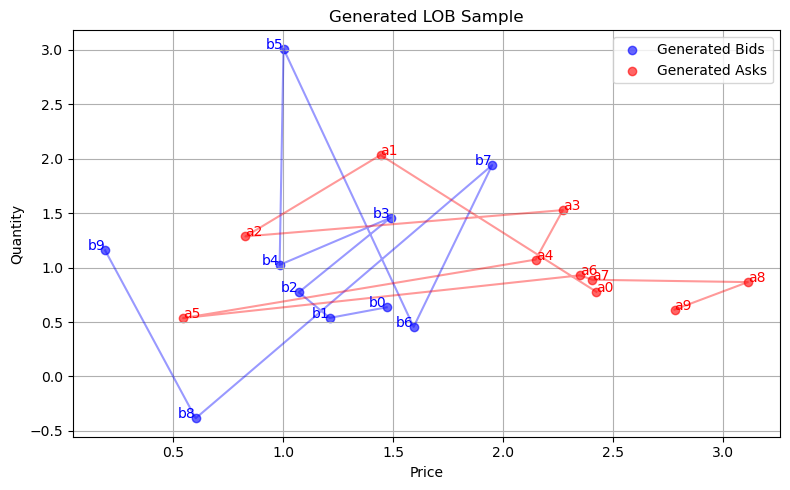

Epoch 1/50 - Gen Loss: 19.8303, Disc Loss: 0.9282, Faulty Rate: 0.3345, Real Prob: 0.4877, Fake Prob: 0.1872
Epoch 2/50 - Gen Loss: 5.4304, Disc Loss: 1.1842, Faulty Rate: 0.1877, Real Prob: 0.5039, Fake Prob: 0.3874
Epoch 3/50 - Gen Loss: 1.6725, Disc Loss: 1.3082, Faulty Rate: 0.1165, Real Prob: 0.5226, Fake Prob: 0.4768
Epoch 4/50 - Gen Loss: 0.9486, Disc Loss: 1.3131, Faulty Rate: 0.1205, Real Prob: 0.5410, Fake Prob: 0.4938
Epoch 5/50 - Gen Loss: 0.7888, Disc Loss: 1.2950, Faulty Rate: 0.0983, Real Prob: 0.5582, Fake Prob: 0.4970
Epoch 6/50 - Gen Loss: 0.7383, Disc Loss: 1.2741, Faulty Rate: 0.0918, Real Prob: 0.5745, Fake Prob: 0.4977
Epoch 7/50 - Gen Loss: 0.7186, Disc Loss: 1.2537, Faulty Rate: 0.0830, Real Prob: 0.5899, Fake Prob: 0.4975
Epoch 8/50 - Gen Loss: 0.7101, Disc Loss: 1.2342, Faulty Rate: 0.0887, Real Prob: 0.6047, Fake Prob: 0.4971
Epoch 9/50 - Gen Loss: 0.7064, Disc Loss: 1.2158, Faulty Rate: 0.0750, Real Prob: 0.6189, Fake Prob: 0.4965
Epoch 10/50 - Gen Loss: 0.7

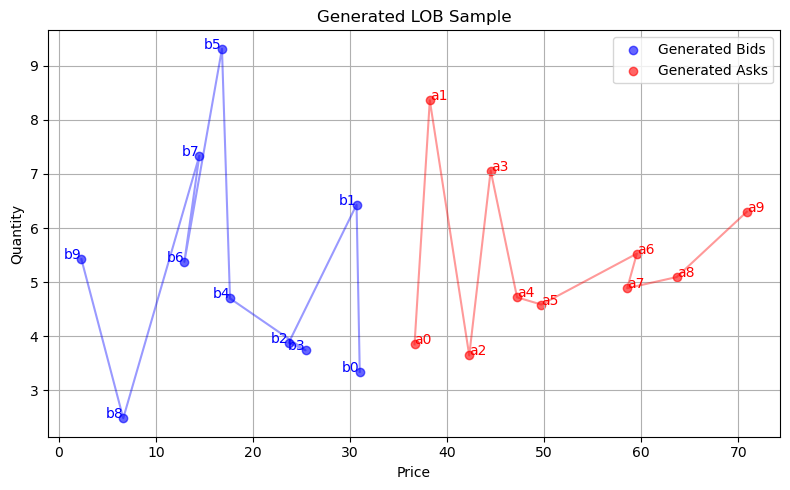

Epoch 11/50 - Gen Loss: 0.7043, Disc Loss: 1.1826, Faulty Rate: 0.0690, Real Prob: 0.6459, Fake Prob: 0.4955
Epoch 12/50 - Gen Loss: 0.7044, Disc Loss: 1.1677, Faulty Rate: 0.0690, Real Prob: 0.6587, Fake Prob: 0.4951
Epoch 13/50 - Gen Loss: 0.7049, Disc Loss: 1.1538, Faulty Rate: 0.0620, Real Prob: 0.6710, Fake Prob: 0.4946
Epoch 14/50 - Gen Loss: 0.7056, Disc Loss: 1.1407, Faulty Rate: 0.0730, Real Prob: 0.6828, Fake Prob: 0.4940
Epoch 15/50 - Gen Loss: 0.7065, Disc Loss: 1.1284, Faulty Rate: 0.0712, Real Prob: 0.6941, Fake Prob: 0.4935
Epoch 16/50 - Gen Loss: 0.7074, Disc Loss: 1.1170, Faulty Rate: 0.0670, Real Prob: 0.7050, Fake Prob: 0.4930
Epoch 17/50 - Gen Loss: 0.7084, Disc Loss: 1.1063, Faulty Rate: 0.0655, Real Prob: 0.7155, Fake Prob: 0.4925
Epoch 18/50 - Gen Loss: 0.7094, Disc Loss: 1.0964, Faulty Rate: 0.0597, Real Prob: 0.7256, Fake Prob: 0.4920
Epoch 19/50 - Gen Loss: 0.7104, Disc Loss: 1.0870, Faulty Rate: 0.0630, Real Prob: 0.7352, Fake Prob: 0.4915
Epoch 20/50 - Gen L

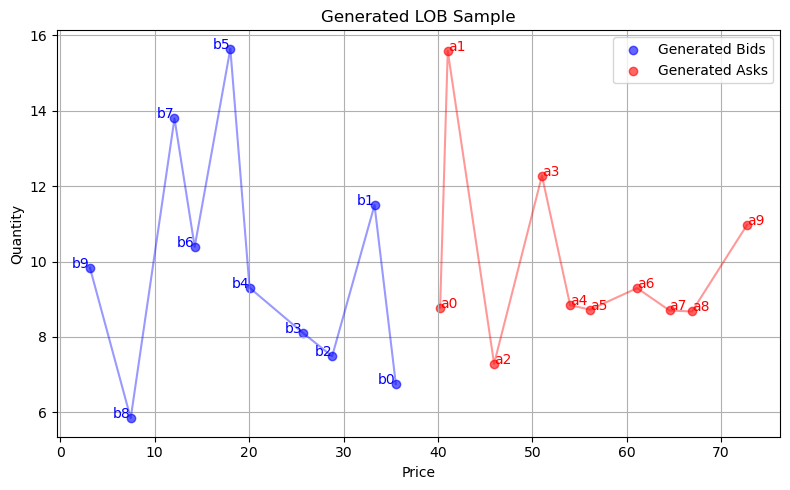

Epoch 21/50 - Gen Loss: 0.7126, Disc Loss: 1.0700, Faulty Rate: 0.0530, Real Prob: 0.7534, Fake Prob: 0.4904
Epoch 22/50 - Gen Loss: 0.7136, Disc Loss: 1.0624, Faulty Rate: 0.0715, Real Prob: 0.7620, Fake Prob: 0.4899
Epoch 23/50 - Gen Loss: 0.7147, Disc Loss: 1.0552, Faulty Rate: 0.0672, Real Prob: 0.7702, Fake Prob: 0.4894
Epoch 24/50 - Gen Loss: 0.7157, Disc Loss: 1.0485, Faulty Rate: 0.0637, Real Prob: 0.7780, Fake Prob: 0.4888
Epoch 25/50 - Gen Loss: 0.7168, Disc Loss: 1.0423, Faulty Rate: 0.0745, Real Prob: 0.7856, Fake Prob: 0.4883


2025-04-06 22:27:23.925803: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/50 - Gen Loss: 0.7178, Disc Loss: 1.0365, Faulty Rate: 0.0498, Real Prob: 0.7928, Fake Prob: 0.4878
Epoch 27/50 - Gen Loss: 0.7189, Disc Loss: 1.0311, Faulty Rate: 0.0530, Real Prob: 0.7997, Fake Prob: 0.4873
Epoch 28/50 - Gen Loss: 0.7199, Disc Loss: 1.0261, Faulty Rate: 0.0570, Real Prob: 0.8063, Fake Prob: 0.4868
Epoch 29/50 - Gen Loss: 0.7210, Disc Loss: 1.0214, Faulty Rate: 0.0562, Real Prob: 0.8126, Fake Prob: 0.4863
Epoch 30/50 - Gen Loss: 0.7220, Disc Loss: 1.0170, Faulty Rate: 0.0487, Real Prob: 0.8186, Fake Prob: 0.4858
Plotting sample


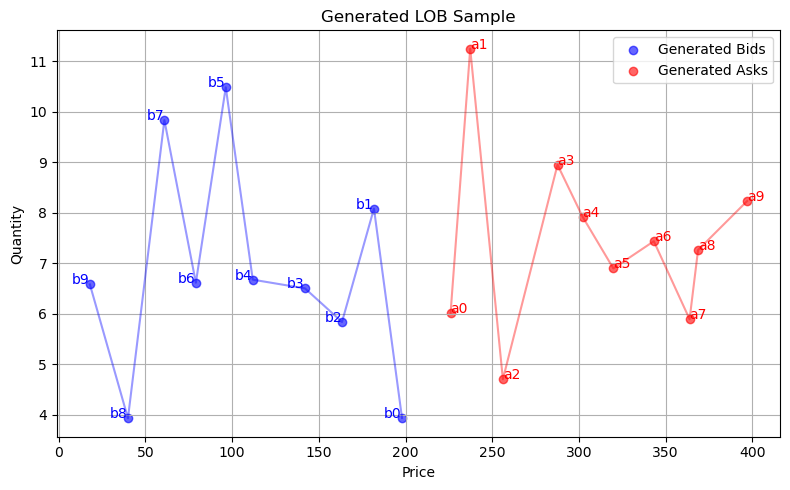

Epoch 31/50 - Gen Loss: 0.7231, Disc Loss: 1.0129, Faulty Rate: 0.0445, Real Prob: 0.8243, Fake Prob: 0.4852
Epoch 32/50 - Gen Loss: 0.7243, Disc Loss: 1.0091, Faulty Rate: 0.0567, Real Prob: 0.8297, Fake Prob: 0.4847
Epoch 33/50 - Gen Loss: 0.7254, Disc Loss: 1.0056, Faulty Rate: 0.0512, Real Prob: 0.8348, Fake Prob: 0.4841
Epoch 34/50 - Gen Loss: 0.7265, Disc Loss: 1.0023, Faulty Rate: 0.0485, Real Prob: 0.8397, Fake Prob: 0.4836
Epoch 35/50 - Gen Loss: 0.7277, Disc Loss: 0.9992, Faulty Rate: 0.0483, Real Prob: 0.8443, Fake Prob: 0.4830
Epoch 36/50 - Gen Loss: 0.7289, Disc Loss: 0.9963, Faulty Rate: 0.0515, Real Prob: 0.8487, Fake Prob: 0.4825
Epoch 37/50 - Gen Loss: 0.7300, Disc Loss: 0.9936, Faulty Rate: 0.0510, Real Prob: 0.8529, Fake Prob: 0.4819
Epoch 38/50 - Gen Loss: 0.7312, Disc Loss: 0.9911, Faulty Rate: 0.0558, Real Prob: 0.8569, Fake Prob: 0.4813
Epoch 39/50 - Gen Loss: 0.7324, Disc Loss: 0.9888, Faulty Rate: 0.0487, Real Prob: 0.8606, Fake Prob: 0.4808
Epoch 40/50 - Gen L

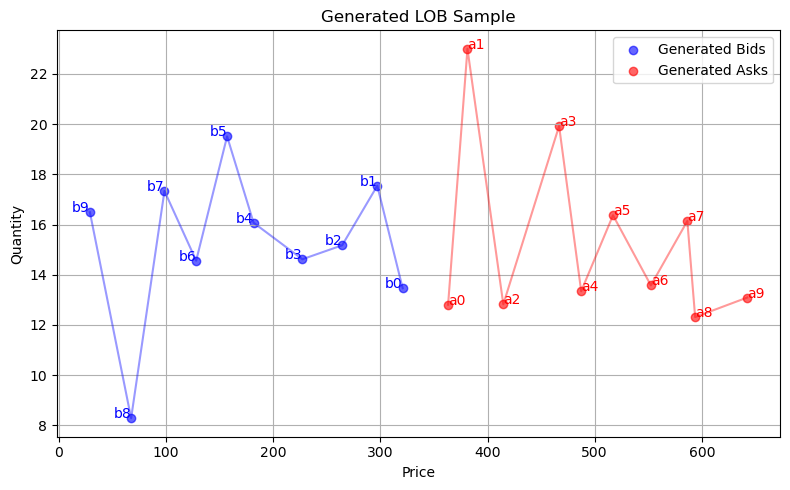

Epoch 41/50 - Gen Loss: 0.7347, Disc Loss: 0.9845, Faulty Rate: 0.0417, Real Prob: 0.8675, Fake Prob: 0.4797
Epoch 42/50 - Gen Loss: 0.7359, Disc Loss: 0.9826, Faulty Rate: 0.0595, Real Prob: 0.8706, Fake Prob: 0.4791
Epoch 43/50 - Gen Loss: 0.7370, Disc Loss: 0.9808, Faulty Rate: 0.0417, Real Prob: 0.8736, Fake Prob: 0.4785
Epoch 44/50 - Gen Loss: 0.7382, Disc Loss: 0.9791, Faulty Rate: 0.0500, Real Prob: 0.8764, Fake Prob: 0.4780
Epoch 45/50 - Gen Loss: 0.7394, Disc Loss: 0.9774, Faulty Rate: 0.0395, Real Prob: 0.8789, Fake Prob: 0.4774
Epoch 46/50 - Gen Loss: 0.7406, Disc Loss: 0.9759, Faulty Rate: 0.0382, Real Prob: 0.8813, Fake Prob: 0.4768
Epoch 47/50 - Gen Loss: 0.7420, Disc Loss: 0.9743, Faulty Rate: 0.0370, Real Prob: 0.8835, Fake Prob: 0.4761
Epoch 48/50 - Gen Loss: 0.7434, Disc Loss: 0.9727, Faulty Rate: 0.0413, Real Prob: 0.8855, Fake Prob: 0.4755
Epoch 49/50 - Gen Loss: 0.7448, Disc Loss: 0.9713, Faulty Rate: 0.0490, Real Prob: 0.8874, Fake Prob: 0.4749


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 50/50 - Gen Loss: 0.7461, Disc Loss: 0.9699, Faulty Rate: 0.0500, Real Prob: 0.8891, Fake Prob: 0.4742


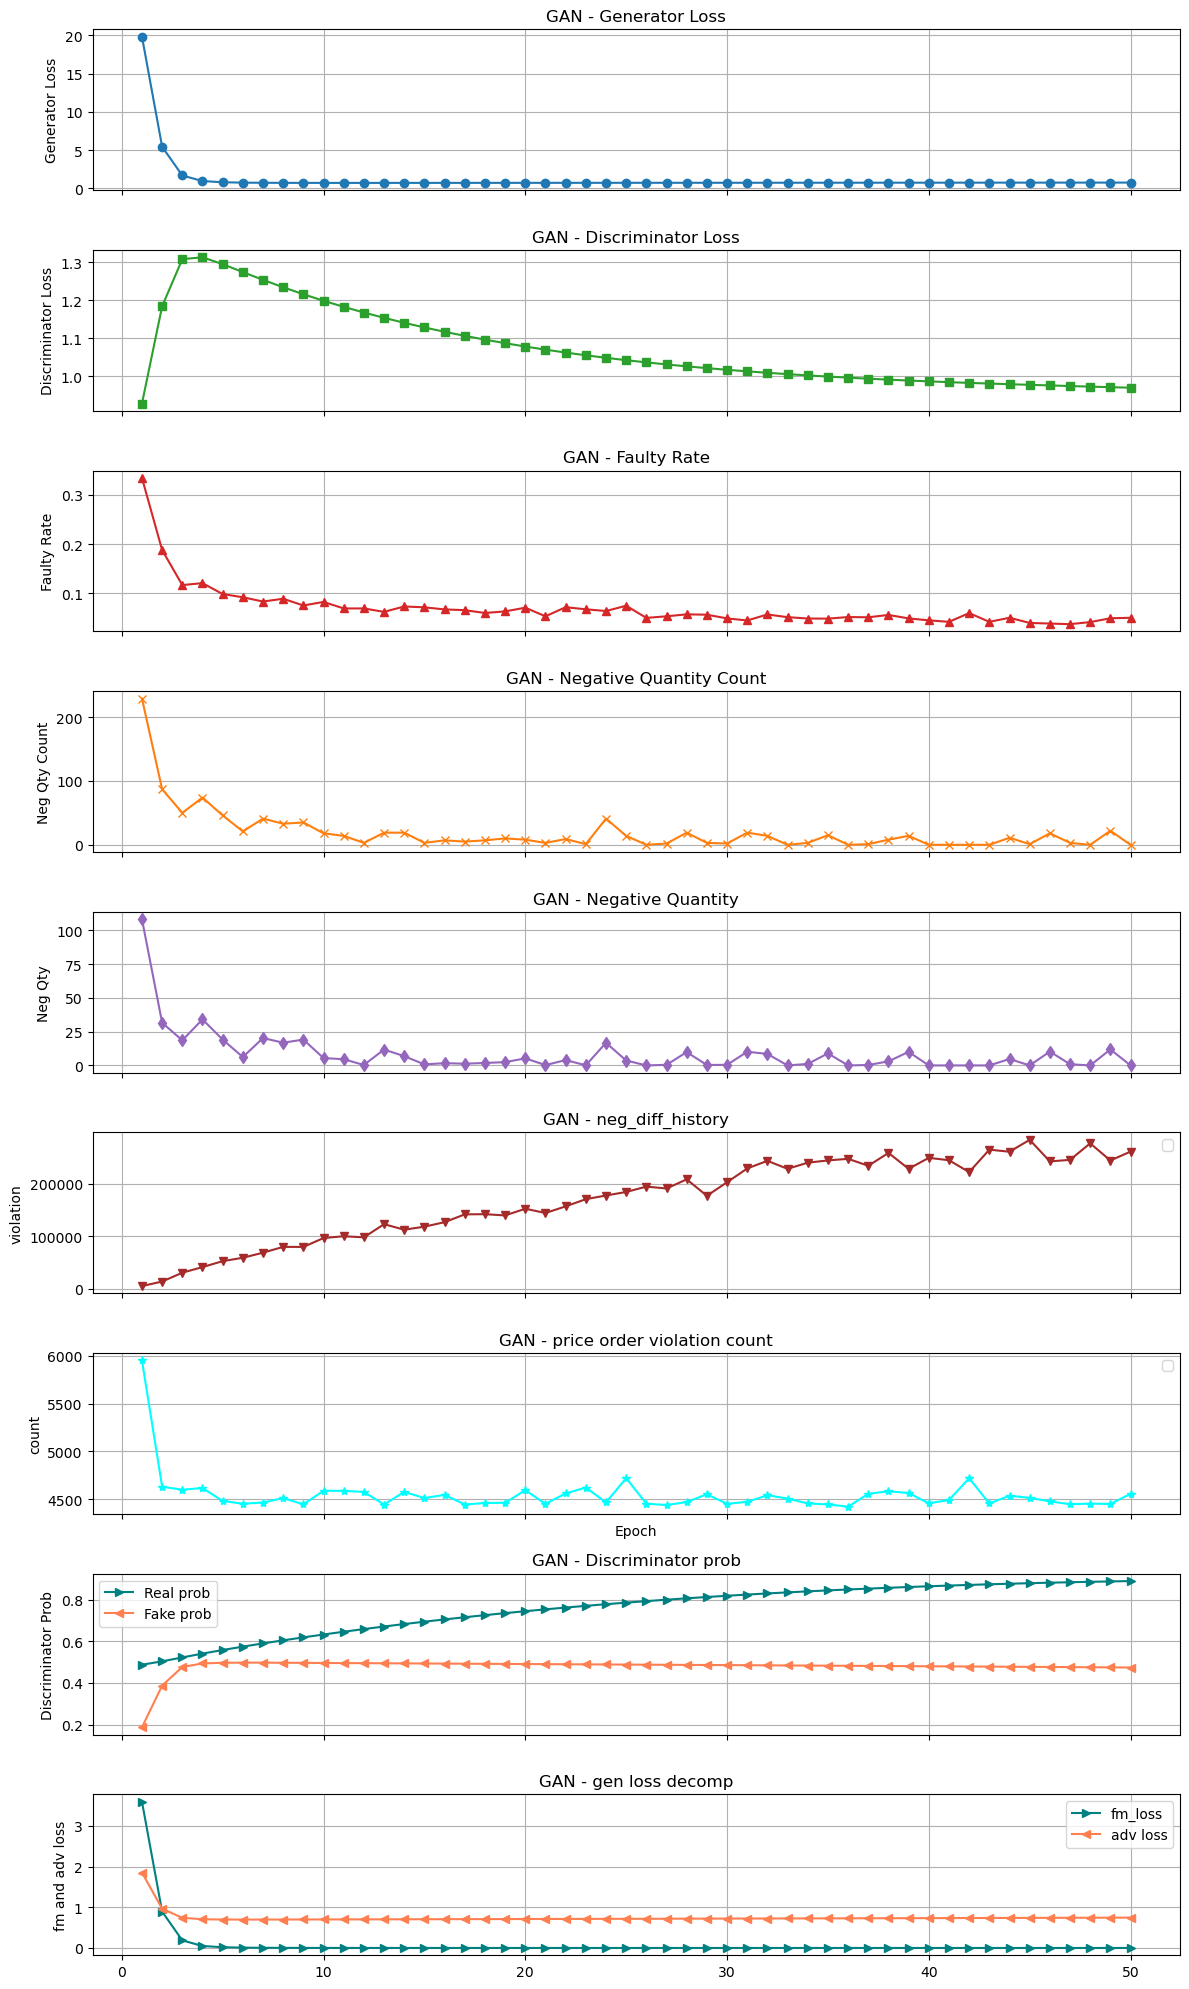

In [44]:
gan = SimpleGAN(config, use_minibatch_discrimination=False)

# History tracking
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
real_prob_history = []
fake_prob_history = []
fm_loss_history = []
adv_loss_history = []

# Faulty stats tracking
neg_qty_history = []
neg_diff_history = []
neg_qty_count_history = []
neg_diff_count_history = []

for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_real_prob = 0.0
    epoch_fake_prob = 0.0
    epoch_fm_loss = 0.0
    epoch_adv_loss = 0.0
    num_batches = 0

    for batch in lob_dataset:
        # Train discriminator once
        real_feature, disc_loss, real_prob, fake_prob = gan.train_step_once(batch)
        epoch_disc_loss += disc_loss
        epoch_real_prob += real_prob
        epoch_fake_prob += fake_prob

        times = 5
        # Train generator multiple times
        for _ in range(times):
            gen_loss, fm_loss, adv_loss = gan.train_generator_step(real_feature)
            epoch_gen_loss += gen_loss
            epoch_fm_loss += fm_loss
            epoch_adv_loss += adv_loss

        num_batches += 1

    avg_gen_loss = epoch_gen_loss / (num_batches * times)
    avg_disc_loss = epoch_disc_loss / num_batches
    avg_real_prob = epoch_real_prob / num_batches
    avg_fake_prob = epoch_fake_prob / num_batches
    avg_fm_loss = epoch_fm_loss / (num_batches *times)
    avg_adv_loss = epoch_adv_loss / (num_batches * times)

    gen_loss_history.append(float(avg_gen_loss))
    disc_loss_history.append(float(avg_disc_loss))
    real_prob_history.append(float(avg_real_prob))
    fake_prob_history.append(float(avg_fake_prob))
    fm_loss_history.append(float(avg_fm_loss))
    adv_loss_history.append(float(avg_adv_loss))

    # Generate LOB samples
    if epoch % 10 == 0:
        noise = tf.random.truncated_normal([1, config.z_dim])
        lob_sample = gan.generator(noise, training=False).numpy()
        print(f"Plotting sample")
        plot_order_book_scatter(lob_sample.flatten())  
        plt.title(f"Generated LOB Sample")
        plt.show()

    noise = tf.random.truncated_normal([100, config.z_dim])
    generated_samples = gan.generator(noise, training=False)
    # Faulty rate and stats
    faulty_rate = compute_faulty_rate(generated_samples)
    faulty_rate_scalar = float(np.mean(faulty_rate))
    faulty_rate_history.append(faulty_rate_scalar)

    stats = compute_faulty_stats(generated_samples)
    neg_qty_history.append(stats["neg_qty"])
    neg_diff_history.append(stats["neg_diff"])
    neg_qty_count_history.append(stats["neg_qty_count"])
    neg_diff_count_history.append(stats["neg_diff_count"])


    print(f"Epoch {epoch+1}/{config.epochs} - "
          f"Gen Loss: {avg_gen_loss:.4f}, "
          f"Disc Loss: {avg_disc_loss:.4f}, "
          f"Faulty Rate: {faulty_rate_scalar:.4f}, "
          f"Real Prob: {avg_real_prob:.4f}, "
          f"Fake Prob: {avg_fake_prob:.4f}")

# Plot everything
plot_training_trends(
    gen_loss_history, 
    disc_loss_history, 
    faulty_rate_history, 
    neg_qty_count_history,
    neg_qty_history,
    neg_diff_history,
    neg_diff_count_history,
    real_prob_history,
    fake_prob_history,
    fm_loss_history,
    adv_loss_history,
    label_prefix="GAN"
)


Plotting sample 1


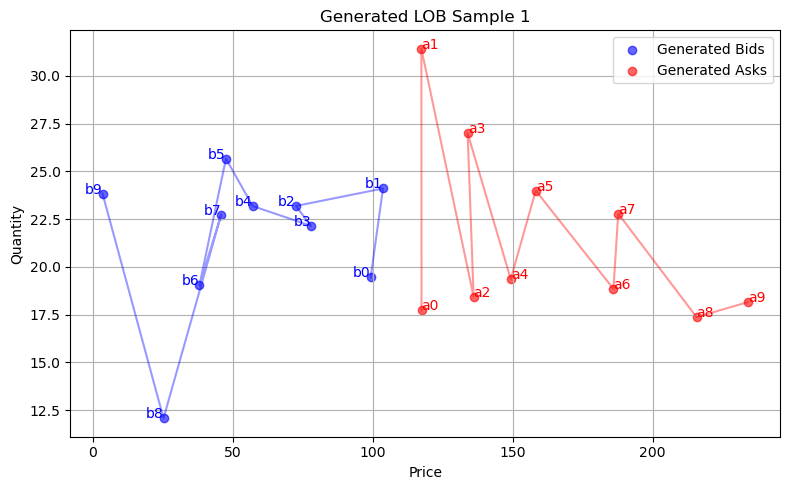

Plotting sample 2


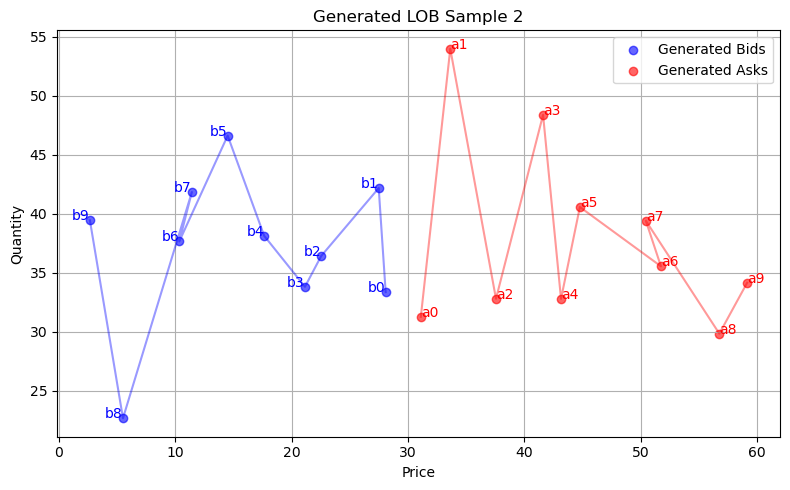

Plotting sample 3


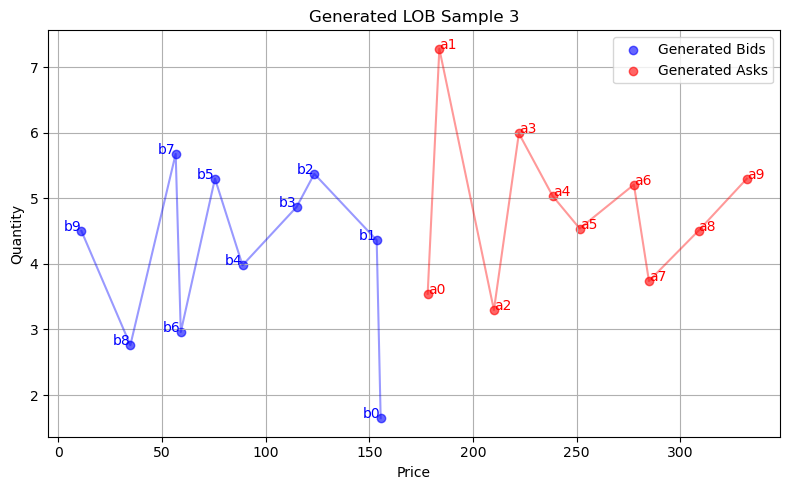

Plotting sample 4


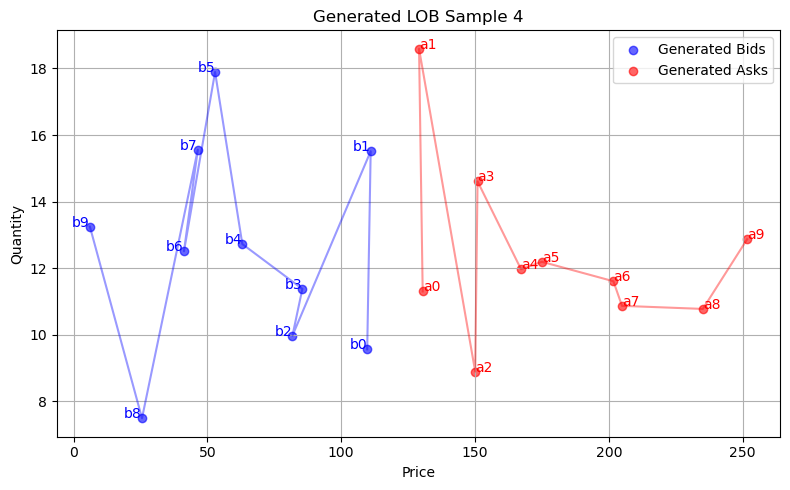

Plotting sample 5


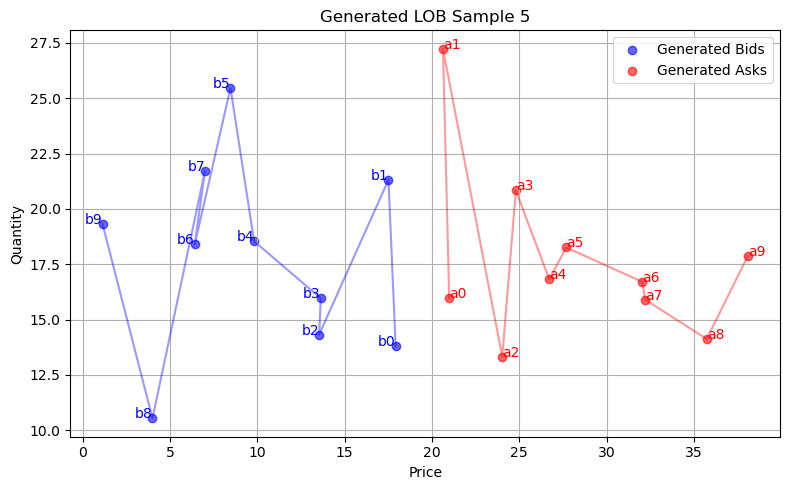

In [45]:
noise = tf.random.truncated_normal([5, config.z_dim])
generated_lob_samples = gan.generator(noise, training=False).numpy()

# Plot each sample using your custom plotting function
for i, lob_sample in enumerate(generated_lob_samples):
    print(f"Plotting sample {i+1}")
    plot_order_book_scatter(lob_sample)  # Assuming df contains your real training data
    plt.title(f"Generated LOB Sample {i+1}")
    plt.show()

### Testing Minibatch Discriminator

/opt/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['discriminator_3/dense_43/kernel', 'discriminator_3/dense_43/bias', 'discriminator_3/dense_44/kernel', 'discriminator_3/dense_44/bias', 'discriminator_3/dense_45/kernel', 'discriminator_3/dense_45/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Plotting sample


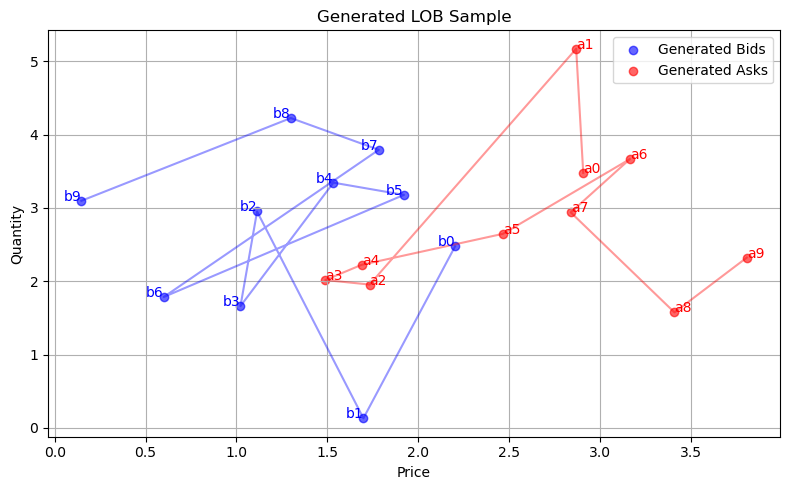

Epoch 1/50 - Gen Loss: 18.0565, Disc Loss: 7.7918, Faulty Rate: 0.3760, Real Prob: 0.9968, Fake Prob: 0.9895
Epoch 2/50 - Gen Loss: 4.8283, Disc Loss: 7.7012, Faulty Rate: 0.2048, Real Prob: 0.9958, Fake Prob: 0.9885
Epoch 3/50 - Gen Loss: 0.9539, Disc Loss: 9.1981, Faulty Rate: 0.1112, Real Prob: 0.9935, Fake Prob: 0.9977
Epoch 4/50 - Gen Loss: 0.2385, Disc Loss: 10.2698, Faulty Rate: 0.1305, Real Prob: 0.9868, Fake Prob: 0.9993
Epoch 5/50 - Gen Loss: 0.0871, Disc Loss: 9.9015, Faulty Rate: 0.1077, Real Prob: 0.9682, Fake Prob: 0.9992
Epoch 6/50 - Gen Loss: 0.0398, Disc Loss: 9.1061, Faulty Rate: 0.0840, Real Prob: 0.9272, Fake Prob: 0.9990
Epoch 7/50 - Gen Loss: 0.0209, Disc Loss: 8.2473, Faulty Rate: 0.0740, Real Prob: 0.8669, Fake Prob: 0.9986
Epoch 8/50 - Gen Loss: 0.0127, Disc Loss: 7.4032, Faulty Rate: 0.0790, Real Prob: 0.8100, Fake Prob: 0.9979
Epoch 9/50 - Gen Loss: 0.0096, Disc Loss: 6.5692, Faulty Rate: 0.0565, Real Prob: 0.7709, Fake Prob: 0.9965
Epoch 10/50 - Gen Loss: 0.

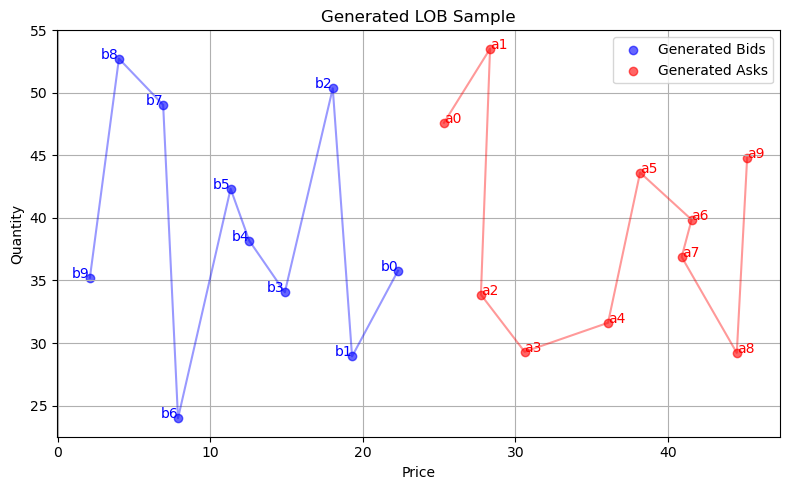

Epoch 11/50 - Gen Loss: 0.0160, Disc Loss: 4.9022, Faulty Rate: 0.0367, Real Prob: 0.7299, Fake Prob: 0.9865
Epoch 12/50 - Gen Loss: 0.0312, Disc Loss: 4.0825, Faulty Rate: 0.0510, Real Prob: 0.7181, Fake Prob: 0.9710
Epoch 13/50 - Gen Loss: 0.0662, Disc Loss: 3.2954, Faulty Rate: 0.0477, Real Prob: 0.7107, Fake Prob: 0.9375
Epoch 14/50 - Gen Loss: 0.1384, Disc Loss: 2.5788, Faulty Rate: 0.0318, Real Prob: 0.7088, Fake Prob: 0.8728
Epoch 15/50 - Gen Loss: 0.2649, Disc Loss: 2.0421, Faulty Rate: 0.0370, Real Prob: 0.7098, Fake Prob: 0.7821
Epoch 16/50 - Gen Loss: 0.4515, Disc Loss: 1.6500, Faulty Rate: 0.0460, Real Prob: 0.7102, Fake Prob: 0.6694
Epoch 17/50 - Gen Loss: 0.6708, Disc Loss: 1.3491, Faulty Rate: 0.0358, Real Prob: 0.7141, Fake Prob: 0.5518
Epoch 18/50 - Gen Loss: 0.9032, Disc Loss: 1.1557, Faulty Rate: 0.0400, Real Prob: 0.7208, Fake Prob: 0.4560
Epoch 19/50 - Gen Loss: 1.1363, Disc Loss: 0.9706, Faulty Rate: 0.0362, Real Prob: 0.7348, Fake Prob: 0.3596
Epoch 20/50 - Gen L

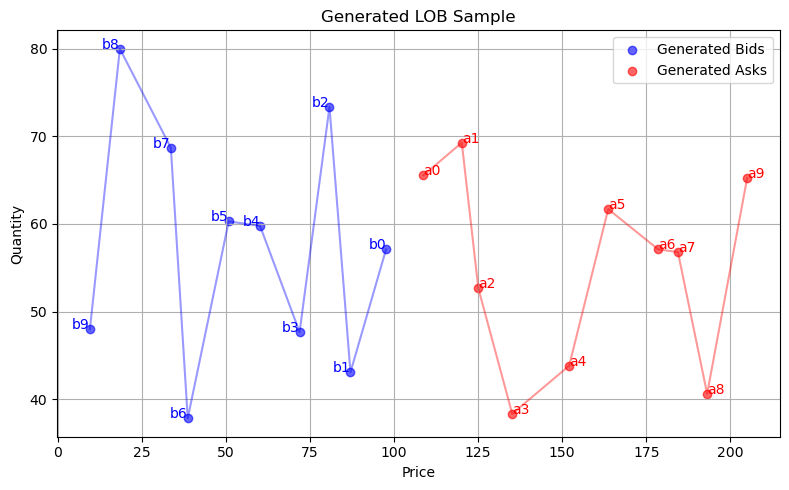

Epoch 21/50 - Gen Loss: 1.5166, Disc Loss: 0.7728, Faulty Rate: 0.0327, Real Prob: 0.7768, Fake Prob: 0.2458
Epoch 22/50 - Gen Loss: 1.6463, Disc Loss: 0.8580, Faulty Rate: 0.0553, Real Prob: 0.7702, Fake Prob: 0.2711
Epoch 23/50 - Gen Loss: 1.8544, Disc Loss: 0.7086, Faulty Rate: 0.0437, Real Prob: 0.7808, Fake Prob: 0.1917
Epoch 24/50 - Gen Loss: 1.9937, Disc Loss: 0.6433, Faulty Rate: 0.0362, Real Prob: 0.7973, Fake Prob: 0.1481
Epoch 25/50 - Gen Loss: 2.0948, Disc Loss: 0.6415, Faulty Rate: 0.0415, Real Prob: 0.8095, Fake Prob: 0.1497
Epoch 26/50 - Gen Loss: 2.2178, Disc Loss: 0.6039, Faulty Rate: 0.0590, Real Prob: 0.8191, Fake Prob: 0.1214
Epoch 27/50 - Gen Loss: 2.3138, Disc Loss: 0.5995, Faulty Rate: 0.0432, Real Prob: 0.8256, Fake Prob: 0.1174
Epoch 28/50 - Gen Loss: 2.4279, Disc Loss: 0.5843, Faulty Rate: 0.0375, Real Prob: 0.8326, Fake Prob: 0.1064
Epoch 29/50 - Gen Loss: 2.4623, Disc Loss: 0.6945, Faulty Rate: 0.0327, Real Prob: 0.8107, Fake Prob: 0.1773
Epoch 30/50 - Gen L

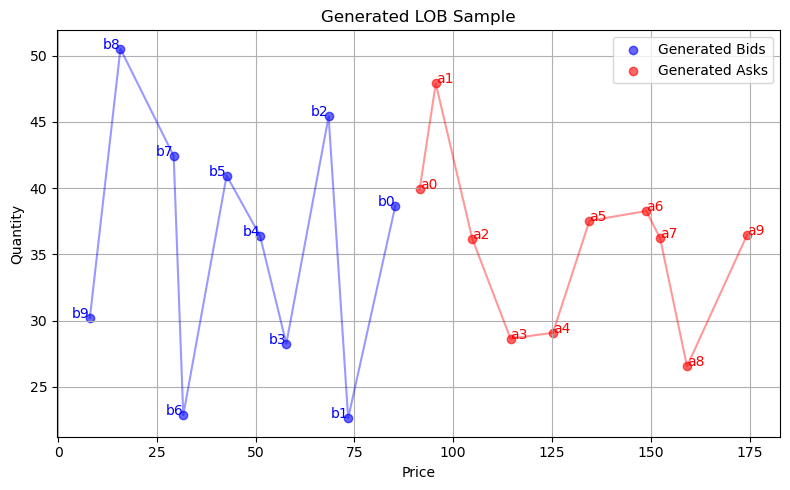

Epoch 31/50 - Gen Loss: 2.8386, Disc Loss: 0.6935, Faulty Rate: 0.0460, Real Prob: 0.7518, Fake Prob: 0.1439
Epoch 32/50 - Gen Loss: 2.8803, Disc Loss: 0.7106, Faulty Rate: 0.0358, Real Prob: 0.7623, Fake Prob: 0.1677
Epoch 33/50 - Gen Loss: 3.0105, Disc Loss: 0.6429, Faulty Rate: 0.0428, Real Prob: 0.7823, Fake Prob: 0.1235
Epoch 34/50 - Gen Loss: 3.0862, Disc Loss: 0.6225, Faulty Rate: 0.0457, Real Prob: 0.7949, Fake Prob: 0.1176
Epoch 35/50 - Gen Loss: 3.1651, Disc Loss: 0.5296, Faulty Rate: 0.0448, Real Prob: 0.8251, Fake Prob: 0.0523
Epoch 36/50 - Gen Loss: 3.1355, Disc Loss: 0.5183, Faulty Rate: 0.0420, Real Prob: 0.8480, Fake Prob: 0.0512
Epoch 37/50 - Gen Loss: 3.1587, Disc Loss: 0.5124, Faulty Rate: 0.0327, Real Prob: 0.8557, Fake Prob: 0.0487
Epoch 38/50 - Gen Loss: 3.1956, Disc Loss: 0.5094, Faulty Rate: 0.0397, Real Prob: 0.8581, Fake Prob: 0.0476
Epoch 39/50 - Gen Loss: 3.2363, Disc Loss: 0.5066, Faulty Rate: 0.0310, Real Prob: 0.8588, Fake Prob: 0.0463
Epoch 40/50 - Gen L

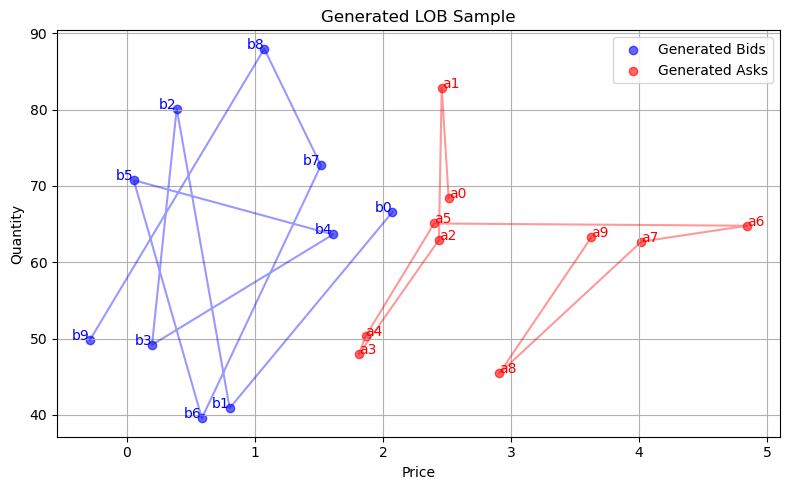

Epoch 41/50 - Gen Loss: 3.3145, Disc Loss: 0.4997, Faulty Rate: 0.0262, Real Prob: 0.8605, Fake Prob: 0.0425
Epoch 42/50 - Gen Loss: 3.3461, Disc Loss: 0.4971, Faulty Rate: 0.0452, Real Prob: 0.8615, Fake Prob: 0.0416
Epoch 43/50 - Gen Loss: 3.3788, Disc Loss: 0.4940, Faulty Rate: 0.0468, Real Prob: 0.8619, Fake Prob: 0.0402
Epoch 44/50 - Gen Loss: 3.4040, Disc Loss: 0.4906, Faulty Rate: 0.0440, Real Prob: 0.8633, Fake Prob: 0.0389
Epoch 45/50 - Gen Loss: 3.4318, Disc Loss: 0.4857, Faulty Rate: 0.0260, Real Prob: 0.8640, Fake Prob: 0.0362
Epoch 46/50 - Gen Loss: 3.4564, Disc Loss: 0.4818, Faulty Rate: 0.0272, Real Prob: 0.8655, Fake Prob: 0.0348
Epoch 47/50 - Gen Loss: 3.4750, Disc Loss: 0.4791, Faulty Rate: 0.0448, Real Prob: 0.8658, Fake Prob: 0.0343
Epoch 48/50 - Gen Loss: 3.4888, Disc Loss: 0.4749, Faulty Rate: 0.0235, Real Prob: 0.8671, Fake Prob: 0.0329
Epoch 49/50 - Gen Loss: 3.5063, Disc Loss: 0.4720, Faulty Rate: 0.0320, Real Prob: 0.8676, Fake Prob: 0.0325


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 50/50 - Gen Loss: 3.5234, Disc Loss: 0.4704, Faulty Rate: 0.0382, Real Prob: 0.8673, Fake Prob: 0.0329


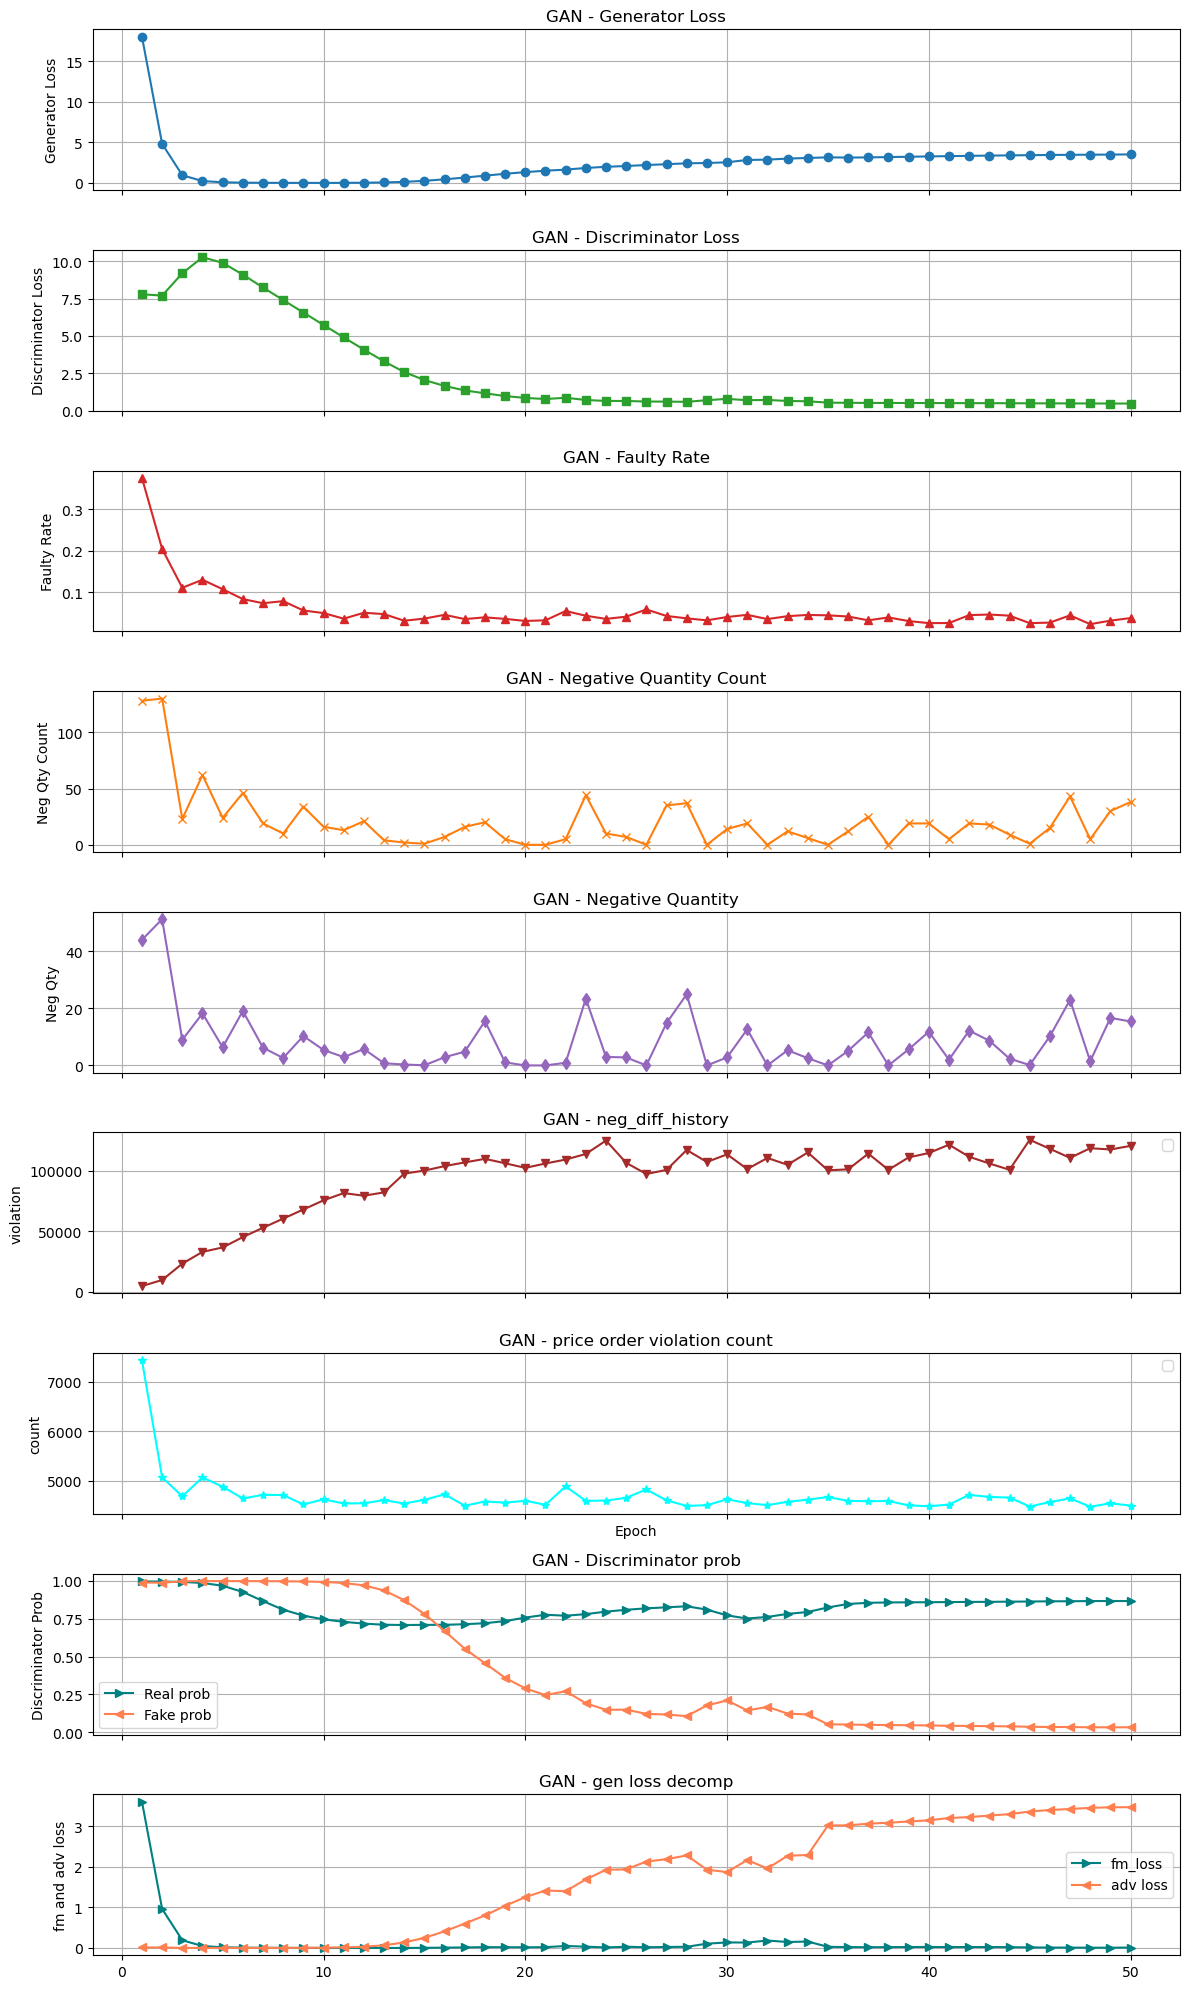

In [46]:
gan = SimpleGAN(config, use_minibatch_discrimination=True)

# History tracking
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
real_prob_history = []
fake_prob_history = []
fm_loss_history = []
adv_loss_history = []

# Faulty stats tracking
neg_qty_history = []
neg_diff_history = []
neg_qty_count_history = []
neg_diff_count_history = []

for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_real_prob = 0.0
    epoch_fake_prob = 0.0
    epoch_fm_loss = 0.0
    epoch_adv_loss = 0.0
    num_batches = 0

    for batch in lob_dataset:
        # Train discriminator once
        real_feature, disc_loss, real_prob, fake_prob = gan.train_step_once(batch)
        epoch_disc_loss += disc_loss
        epoch_real_prob += real_prob
        epoch_fake_prob += fake_prob

        times = 5
        # Train generator multiple times
        for _ in range(times):
            gen_loss, fm_loss, adv_loss = gan.train_generator_step(real_feature)
            epoch_gen_loss += gen_loss
            epoch_fm_loss += fm_loss
            epoch_adv_loss += adv_loss

        num_batches += 1

    avg_gen_loss = epoch_gen_loss / (num_batches * times)
    avg_disc_loss = epoch_disc_loss / num_batches
    avg_real_prob = epoch_real_prob / num_batches
    avg_fake_prob = epoch_fake_prob / num_batches
    avg_fm_loss = epoch_fm_loss / (num_batches *times)
    avg_adv_loss = epoch_adv_loss / (num_batches * times)

    gen_loss_history.append(float(avg_gen_loss))
    disc_loss_history.append(float(avg_disc_loss))
    real_prob_history.append(float(avg_real_prob))
    fake_prob_history.append(float(avg_fake_prob))
    fm_loss_history.append(float(avg_fm_loss))
    adv_loss_history.append(float(avg_adv_loss))

    # Generate LOB samples
    if epoch % 10 == 0:
        noise = tf.random.truncated_normal([1, config.z_dim])
        lob_sample = gan.generator(noise, training=False).numpy()
        print(f"Plotting sample")
        plot_order_book_scatter(lob_sample.flatten())  
        plt.title(f"Generated LOB Sample")
        plt.show()

    noise = tf.random.truncated_normal([100, config.z_dim])
    generated_samples = gan.generator(noise, training=False)
    # Faulty rate and stats
    faulty_rate = compute_faulty_rate(generated_samples)
    faulty_rate_scalar = float(np.mean(faulty_rate))
    faulty_rate_history.append(faulty_rate_scalar)

    stats = compute_faulty_stats(generated_samples)
    neg_qty_history.append(stats["neg_qty"])
    neg_diff_history.append(stats["neg_diff"])
    neg_qty_count_history.append(stats["neg_qty_count"])
    neg_diff_count_history.append(stats["neg_diff_count"])


    print(f"Epoch {epoch+1}/{config.epochs} - "
          f"Gen Loss: {avg_gen_loss:.4f}, "
          f"Disc Loss: {avg_disc_loss:.4f}, "
          f"Faulty Rate: {faulty_rate_scalar:.4f}, "
          f"Real Prob: {avg_real_prob:.4f}, "
          f"Fake Prob: {avg_fake_prob:.4f}")

# Plot everything
plot_training_trends(
    gen_loss_history, 
    disc_loss_history, 
    faulty_rate_history, 
    neg_qty_count_history,
    neg_qty_history,
    neg_diff_history,
    neg_diff_count_history,
    real_prob_history,
    fake_prob_history,
    fm_loss_history,
    adv_loss_history,
    label_prefix="GAN"
)


Plotting sample 1


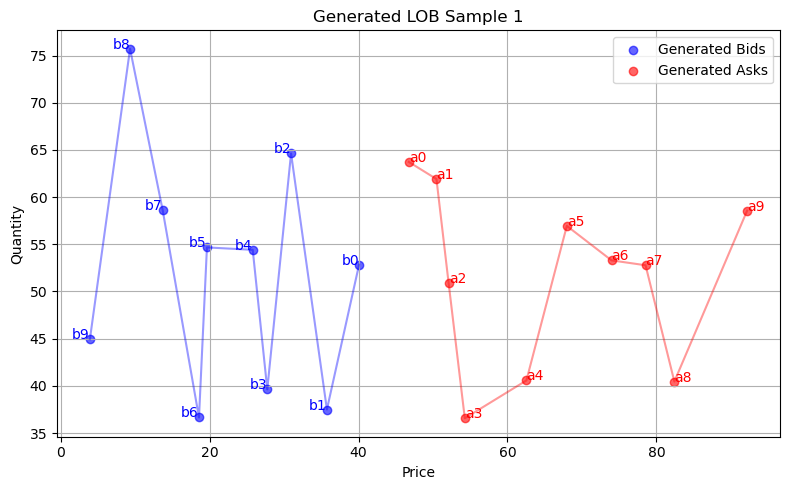

Plotting sample 2


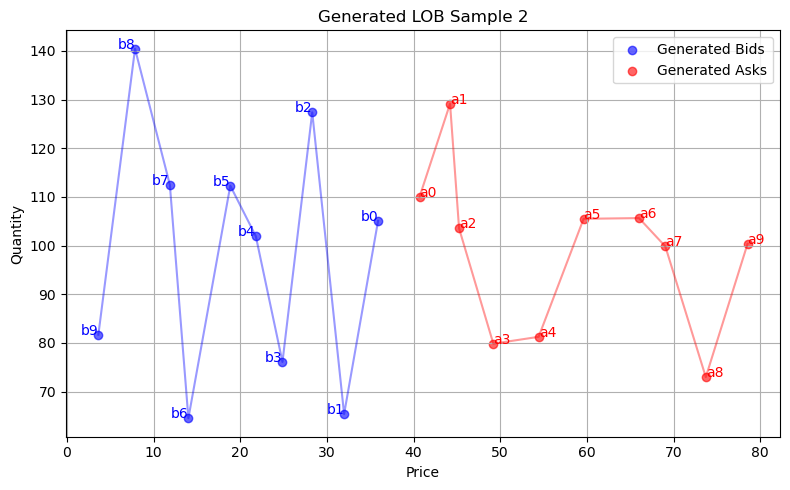

Plotting sample 3


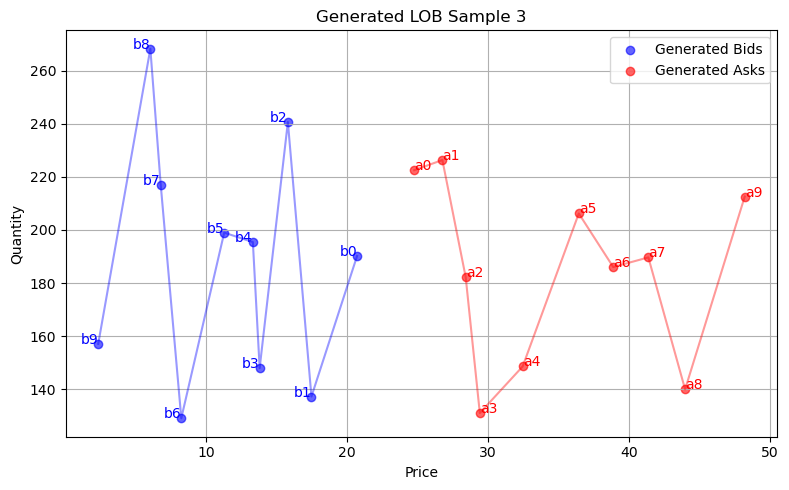

Plotting sample 4


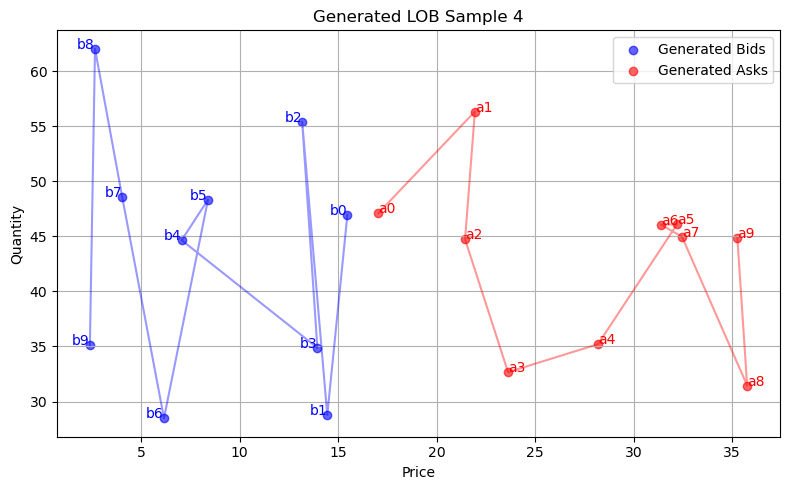

Plotting sample 5


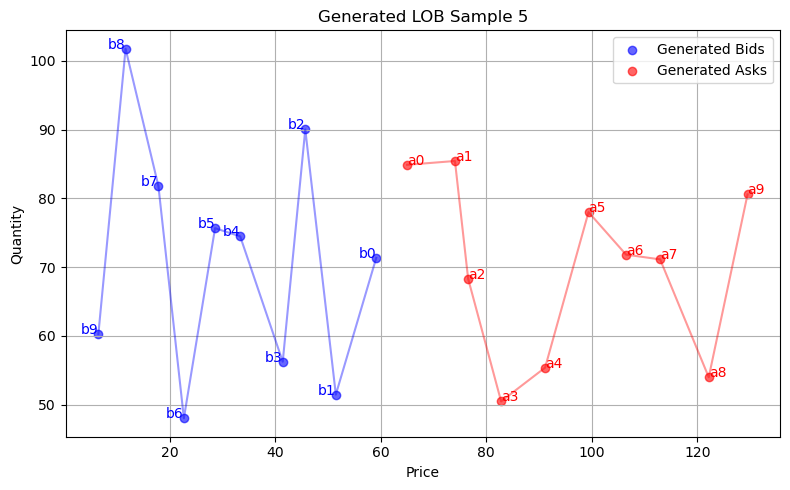

In [47]:
noise = tf.random.truncated_normal([5, config.z_dim])
generated_lob_samples = gan.generator(noise, training=False).numpy()

# Plot each sample using your custom plotting function
for i, lob_sample in enumerate(generated_lob_samples):
    print(f"Plotting sample {i+1}")
    plot_order_book_scatter(lob_sample)  # Assuming df contains your real training data
    plt.title(f"Generated LOB Sample {i+1}")
    plt.show()